In [1]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import os
import shutil

%matplotlib ipympl
np.random.seed(23061998)
import gzip
RANDOM_SEED = 23061998

plt.style.use('default')

In [15]:
def extract_reps(confs_df: pd.DataFrame, res_i_name: str, res_name: str, n_optimal: int):
    gaussian = True
    
    all_df = pd.read_csv(confs_df, index_col=0)
    if res_name == 'ARG':
        samples = all_df.iloc[:,-4:-1].to_numpy() #training set is all data points in space
    elif res_name == 'LYS':
        samples = all_df.iloc[:,-4:-2].to_numpy()
    else:
        raise ValueError("The residue chosen is not compatible with this analysis")
    scaler = MinMaxScaler()
    scaler.fit(samples)
    scaled_samples = scaler.transform(samples)
    
    
    if gaussian == True:
        optimal_gmm = GaussianMixture(n_components=n_optimal, random_state=RANDOM_SEED)
        optimal_gmm.fit(scaled_samples)
        labels = optimal_gmm.predict(scaled_samples)

    
    else:
        clustering = AgglomerativeClustering(n_clusters=n_optimal)
        labels = clustering.fit_predict(samples)
    # clustering.centroids
        
    all_df['clustering_lables'] = labels

    # clustering.centroids
    nearest_centroids = NearestCentroid()
    nearest_centroids.fit(scaled_samples, labels)
    centroids = nearest_centroids.centroids_
    #nearest_neightbor = NearestNeighbors(n_neighbors=1)
    # print(centroids.shape)
    inverse_centroid = scaler.inverse_transform(centroids)
    # print('X')
    #print(inverse_centroid)
    
    nearest_neightbor = NearestNeighbors(n_neighbors=1)
    rep_per_label = {} #parameters in 3 coord of representors
    rep_non_scaled = {} #indices in the all atom array
    rep_indices = []
    
    for label, centorid in enumerate(centroids):
        #print(centorid,label)
        labels_arr = all_df['clustering_lables'].to_numpy()
        idx = np.where(labels_arr == label)
        idx = np.ravel(idx)
                
        samples_for_label = scaled_samples[idx]
        non_scaled_samples = samples[idx]
        #now extract the index in indices list. that's nearest group's centoid:
        rep = nearest_neightbor.fit(samples_for_label).kneighbors(centorid.reshape(1,-1), return_distance=False)[:,0]
        #print(rep)
        rep_per_label[label] = samples_for_label[rep][0,:]
        
        rep_non_scaled[label] = non_scaled_samples[rep][0,:]
        
        int_rep = int(rep)
        curr_rep = idx[int_rep]
        rep_indices.append(curr_rep)


    reps_arr = []
    for key in range(len(rep_per_label)):
        reps_arr.append(rep_per_label[key])
    reps_arr = np.array(reps_arr)
    
    non_scaled_reps_arr = []
    for key in range(len(rep_non_scaled)):
        non_scaled_reps_arr.append(rep_non_scaled[key])
    non_scaled_reps_arr = np.array(non_scaled_reps_arr)

    
    #all members array:
    all_df.iloc[rep_indices,:4].to_csv(f'csv_files/{res_i_name}_{res_name}_rep_confs.csv')
    
    # if not os.path.isdir(f"../{res_i_name}_{res_name}_xyz"):
    #     os.makedirs(f"../{res_i_name}_{res_name}_xyz")
    # all_confs_df = pd.read_csv(f'{res_i_name}_{res_name}_rep_confs.csv', index_col=0)
    # for pdb_file in all_confs_df.iloc[:,0].values.tolist():
    #     gzip_file = f"../{pdb_file}.gz"
    #     with gzip.open(gzip_file, 'rb') as f_in:
    #         with open(f"../{res_i_name}_{res_name}_xyz/{pdb_file}", 'wb') as f_out:
    #             shutil.copyfileobj(f_in, f_out)
    return centroids, reps_arr, non_scaled_reps_arr, samples, labels             



def find_representative_confs(data_file: str, n_optimal: int, res_i_name) -> np.ndarray:
    """finds a single closest geometry point in the space of D (rescaled), Ttheta1, Ttheta2.
        The representative points should be closest to the average of each variable (D,T1,T2).
        
    Arguments:
    ---
        @ all_df: a pandas dataframe containing all conformations found in pdb for the given pair
        @ major_df: a pandas dataframe containing screened populated categories generated by the categorized_datapoints function
    
    Returns:
    ---
        @ a numpy array containing indices of the representative confs for each category. Indices point to the confs
        in all_df 
    """
    # data_file = 'fixed_PHE_cationpi.csv'
    data = pd.read_csv(data_file)
    cond = data['Theta2'].isna() == True
    cond_arg = data['Theta2'].isna() == False
    res_i_lys = data[cond]

    res_i_arg = data[cond_arg]
    res_i_arg.to_csv(f'csv_files/{res_i_name}_ARG.csv', index=0)
    res_i_lys.to_csv(f'csv_files/{res_i_name}_LYS.csv',index=0)
    
   
    #### ARG 
    all_confs_path_arg = f"csv_files/{res_i_name}_ARG.csv"
    centroids, reps_arr, non_scaled_reps_arr, samples, labels = extract_reps(all_confs_path_arg, res_i_name, 'ARG', n_optimal)
    
    all_confs_path_lys = f"csv_files/{res_i_name}_LYS.csv"
    centroids1, reps_arr1, non_scaled_reps_arr1, samples1, labels1 = extract_reps(all_confs_path_lys, res_i_name, 'LYS', n_optimal)    
        
    return centroids, reps_arr, non_scaled_reps_arr, samples, labels



In [16]:
n_optimal = 72
data_file = 'csv_files/PHE_cationpi_Hb.csv'
cents,reps_scaled,reps_origin,samples,labels = find_representative_confs(data_file, n_optimal, 'PHE')

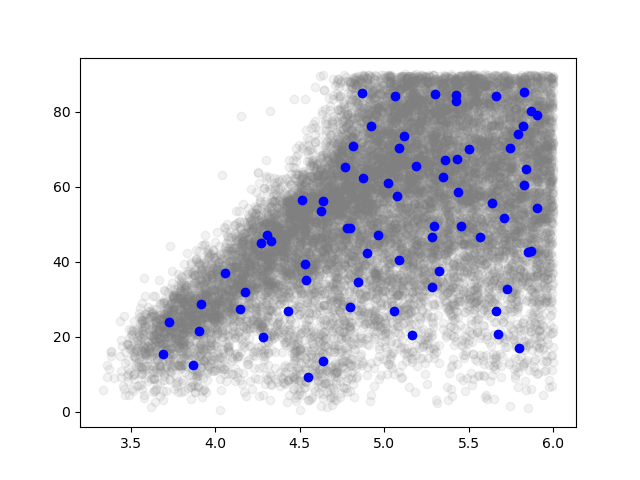

In [19]:
##gaussian clustering!!
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(samples[:,0],samples[:,1],c='gray',alpha=0.1)
ax.scatter(reps_origin[:,0],reps_origin[:,1],c='blue')

plt.show()

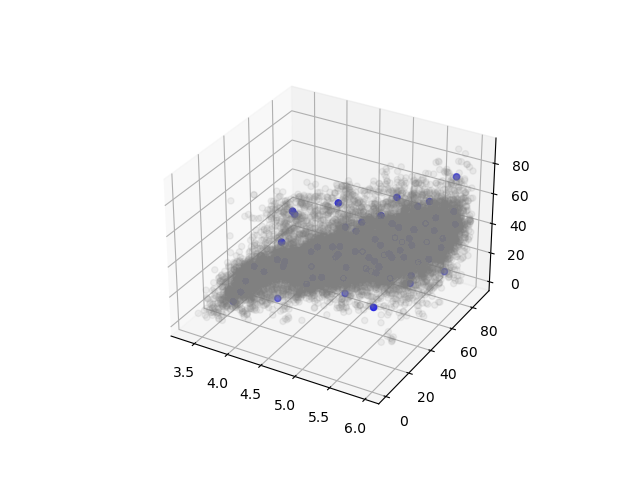

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(samples[:,0],samples[:,1],samples[:,2],c='gray',alpha=0.1)
ax.scatter(reps_origin[:,0],reps_origin[:,1],reps_origin[:,2],c='blue')

plt.show()